### Goal
 prediction models that predict taxi trip demand using support vector machines in spatio-temporal resolution (i.e., spatial-unit and time buckets). Your method should predict for each spatial unit (hexagon and census tract) and time-basket (e.g., 08am-11.59am) the taxi demand. Also adevise a reasonable validation strategy for your prediction model (i.e., definition of test, training data etc).

Approach for SVM:
- Simply start without a kernel. Then, gradually make your model complex by integrating different
kind of kernels. Also, use grid search to find optimal values for your hyperparameters.
- How good is your model? Evaluate your model’s performance and comment on its shortfalls.
- Show how you model’s performance varies as you increase or decrease temporal resolution for the
following period length: 1h, 2h, 6h, 24h. Also, vary the length of the hexagon edges. How does your
performance change when you only use census tract as spatial units?
- How could the model be improved further? Explain some of the improvement levers that you might
focus on in a follow-up project.


## Test on Synthetic Data

In [1]:
import numpy as np
from sklearn.svm import SVR

# Example dataset
time_bucket = np.array([1, 2, 3, 4, 5])  # Input variable 1: Time bucket
spatial_unit = np.array([10, 20, 30, 40, 50])  # Input variable 2: Spatial unit
taxi_demand = np.array([100, 200, 150, 250, 180])  # Target variable: Taxi demand

# Reshape the input variables
time_bucket = time_bucket.reshape(-1, 1)
spatial_unit = spatial_unit.reshape(-1, 1)

# Concatenate the input variables
X = np.concatenate((time_bucket, spatial_unit), axis=1)

# Create and train the SVR model without a kernel
svr = SVR(kernel='linear')
svr.fit(X, taxi_demand)

# Predicting on new data
new_time_bucket = np.array([6, 7, 8])  # New time bucket values
new_spatial_unit = np.array([60, 70, 80])  # New spatial unit values
new_X = np.concatenate((new_time_bucket.reshape(-1, 1), new_spatial_unit.reshape(-1, 1)), axis=1)
predictions = svr.predict(new_X)

print("Predicted taxi demand:", predictions)


Predicted taxi demand: [195.1 210.1 225.1]


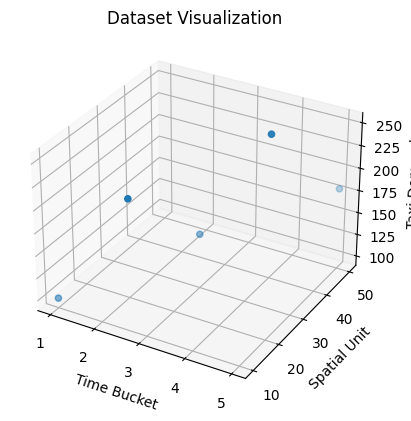

In [2]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Example dataset
time_bucket = np.array([1, 2, 3, 4, 5])  # Input variable 1: Time bucket
spatial_unit = np.array([10, 20, 30, 40, 50])  # Input variable 2: Spatial unit
taxi_demand = np.array([100, 200, 150, 250, 180])  # Target variable: Taxi demand

# Create a 3D figure
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Scatter plot the dataset
ax.scatter(time_bucket, spatial_unit, taxi_demand)

# Set labels and title
ax.set_xlabel('Time Bucket')
ax.set_ylabel('Spatial Unit')
ax.set_zlabel('Taxi Demand')
ax.set_title('Test Dataset Visualization')

# Show the plot
plt.show()


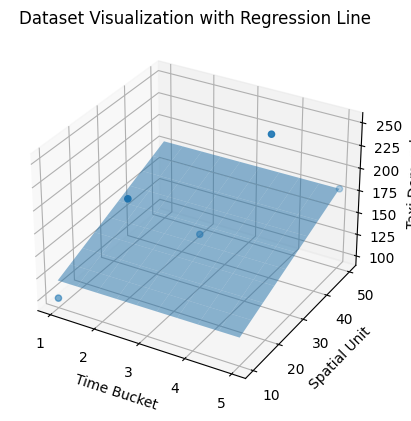

In [3]:
from mpl_toolkits.mplot3d import Axes3D


# Example dataset
time_bucket = np.array([1, 2, 3, 4, 5])  # Input variable 1: Time bucket
spatial_unit = np.array([10, 20, 30, 40, 50])  # Input variable 2: Spatial unit
taxi_demand = np.array([100, 200, 150, 250, 180])  # Target variable: Taxi demand

# Create and train the SVR model
svr = SVR(kernel='linear')
svr.fit(np.column_stack((time_bucket, spatial_unit)), taxi_demand)

# Create a meshgrid of time_bucket and spatial_unit values
time_bucket_mesh, spatial_unit_mesh = np.meshgrid(
    np.linspace(time_bucket.min(), time_bucket.max(), 10),
    np.linspace(spatial_unit.min(), spatial_unit.max(), 10)
)

# Flatten the meshgrid points and make predictions
X_mesh = np.column_stack((time_bucket_mesh.flatten(), spatial_unit_mesh.flatten()))
predictions = svr.predict(X_mesh)

# Create a 3D figure
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Scatter plot the dataset
ax.scatter(time_bucket, spatial_unit, taxi_demand)

# Plot the regression surface
ax.plot_surface(time_bucket_mesh, spatial_unit_mesh, predictions.reshape(time_bucket_mesh.shape), alpha=0.5)

# Set labels and title
ax.set_xlabel('Time Bucket')
ax.set_ylabel('Spatial Unit')
ax.set_zlabel('Taxi Demand')
ax.set_title('Test Dataset Visualization with Regression Line')

# Show the plot
plt.show()


## Data Preparation

In [1]:
# Imports
import vaex
import pandas as pd
import numpy as np
import geopandas as gp
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
timeB = 4
resolution = 7
hdf = vaex.open("data/trips/trips_grouped_" + str(timeB) + "h_r" + str(resolution) + ".hdf5")
df = hdf.to_pandas_df()

In [3]:
df.columns

Index(['start_day', 'start_month', 'start_weekday', 'start_weekday_sin',
       'start_weekday_cos', 'ts_start_4_hour', 'start_4_hour',
       'start_4_hour_sin', 'start_4_hour_cos', 'pickup_hex_7', 'demand',
       'Trip Seconds', 'Trip Miles', 'Fare', 'Tips', 'Tolls', 'Extras',
       'Trip Total', 'Company_encoded', 'Taxi ID_encoded',
       'Payment Type_Dispute', 'Payment Type_Unknown', 'Payment Type_Prcard',
       'Payment Type_Cash', 'Payment Type_Credit Card', 'Payment Type_Pcard',
       'Payment Type_No Charge'],
      dtype='object')

In [5]:
# Independent variables columns
iVars = ["start_weekday_sin", "start_weekday_cos",  "start_4_hour_sin", 'start_4_hour',  "start_4_hour_cos", "pickup_hex_7"]

# All interesting columns
iColumns = ["demand"] + iVars

# Select interesting columns
sdf = df[iColumns]

In [6]:
# Removing Rides without a Hexagon/ Start-Location
sdf = sdf[(sdf["pickup_hex_7"].notna()) & (sdf["pickup_hex_7"] != "None")]

In [7]:
# Divide into X and y
data = sdf
X = data[iVars]
y = data["demand"]

# Convert into float for Keras
#X = X.astype("float32")
#y = y.astype("float")

In [8]:
# Print shape to know, that it fits for model
print('X shape:', X.shape)
print('y shape:', y.shape)

X shape: (144512, 6)
y shape: (144512,)


In [9]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle= True)
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle = True)

- problem 1: keine one hot encoding für sv -> sparse data
- problem 2: hexagon id als categorical so nicht verwertbar
- problem 3: spatial autocorrelation ist spatial als feature aussagekräftig oder nur zur unterteilung gedacht? 

## Regression mit weekday und 4_hour

In [10]:
X_mvp = X.drop(['start_4_hour', "pickup_hex_7"], axis=1)

In [11]:
## mvp nur mit demand und start4_hour + start weekday
X_mvp.head(5)

,start_weekday_sin,start_weekday_cos,start_4_hour_sin,start_4_hour_cos
0,0.433884,-0.900969,0.000000e+00,1.0
1,-0.781831,0.623490,-4.898587e-16,1.0
2,-0.433884,-0.900969,8.660254e-01,-0.5
3,0.000000,1.000000,-8.660254e-01,-0.5
4,0.433884,-0.900969,8.660254e-01,-0.5


In [18]:
X_train, X_test, y_train, y_test = train_test_split(X_mvp, y, test_size=0.2, shuffle= True)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle = True)

In [20]:
from sklearn.svm import SVR
svr = SVR(kernel='linear')
svr.fit(X_train, y_train)

SVR(kernel='linear')

In [21]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_pred = svr.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print evaluation results
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R-squared:", r2)

Mean Squared Error: 748134.3743187881
Mean Absolute Error: 219.5852915753111
R-squared: -0.06280716510670703


scaling target variable 

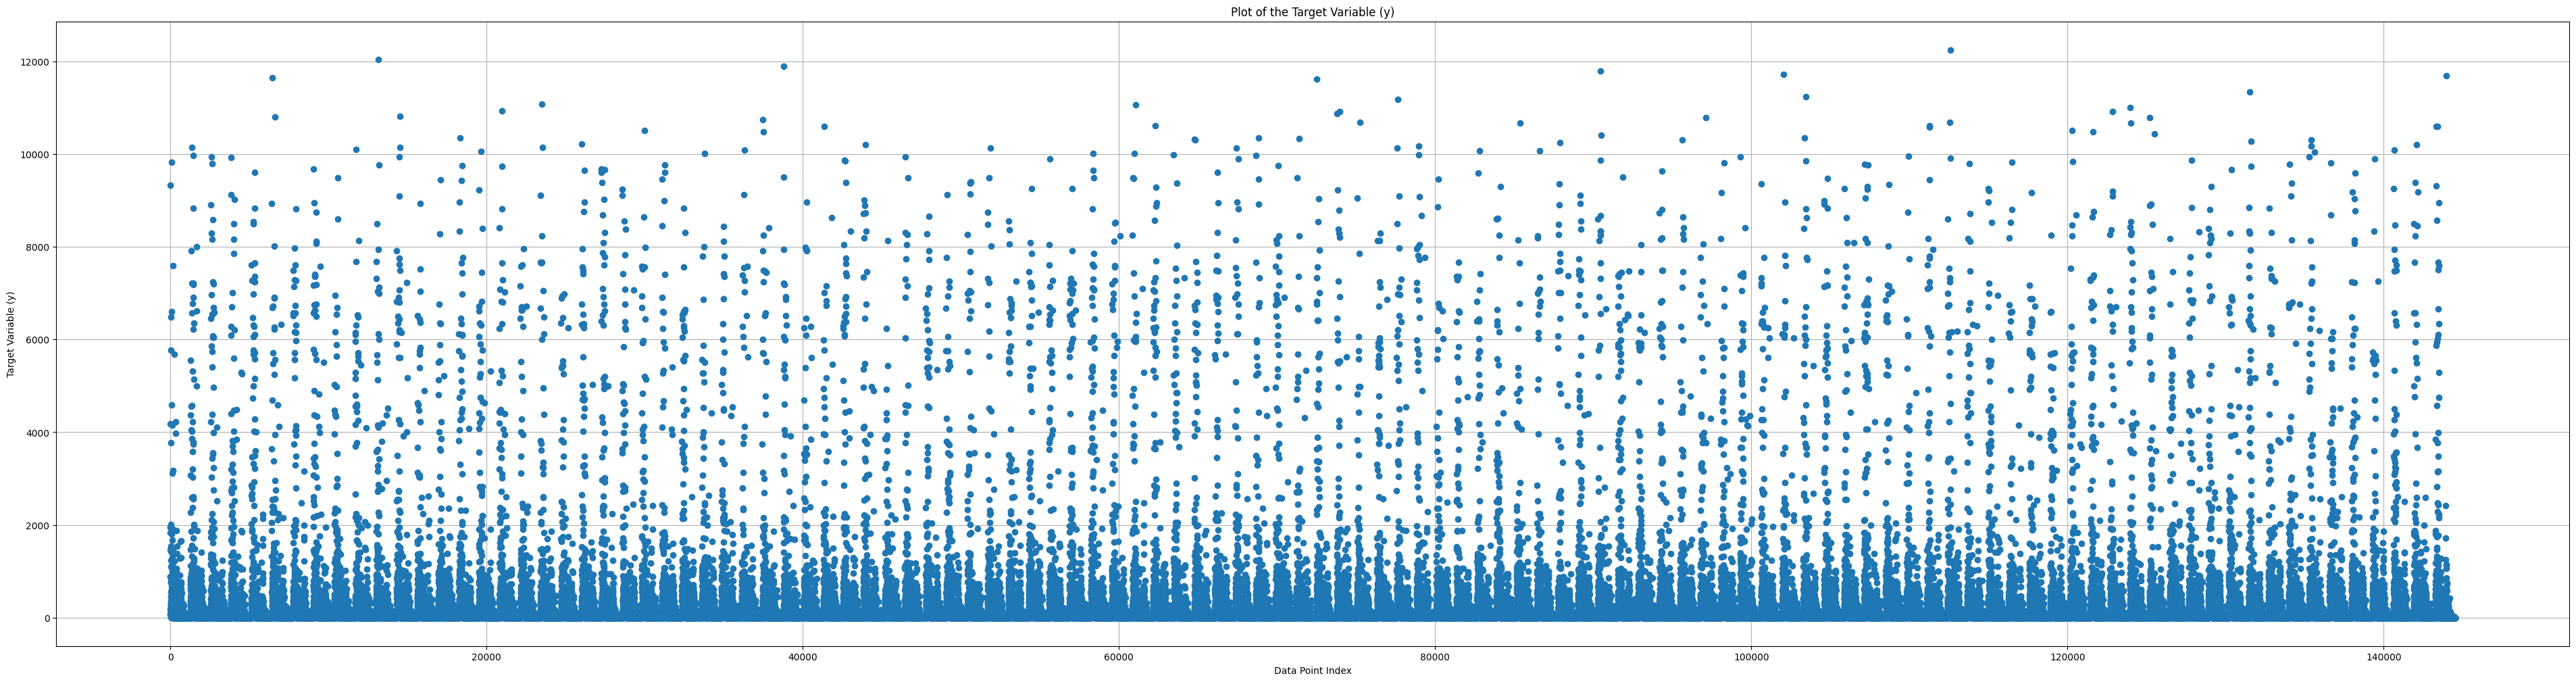

In [ ]:
import matplotlib.pyplot as plt

x = np.arange(len(y))

# Plot the target variable y
plt.figure(figsize=(48, 12))
plt.plot(x, y, marker='o', linestyle="")
plt.xlabel('Data Point Index')
plt.ylabel('Target Variable (y)')
plt.title('Plot of the Target Variable (y)')
plt.grid(True)
plt.show()

In [27]:
## same model with scaled target feature
from sklearn.compose import TransformedTargetRegressor

target_scaler = StandardScaler()
target_scaler.fit(y.values.reshape(-1, 1))

# Initialize the TransformedTargetRegressor
transformed_regressor = TransformedTargetRegressor(regressor=svr, transformer=target_scaler)

# Fit the TransformedTargetRegressor with the transformed target variable
transformed_regressor.fit(X_mvp, y)

# predict 
y_transformed_pred = transformed_regressor.predict(X_test)



In [32]:
# Inverse transform the predictions to get them back to the original scale
y_transformed_pred_original_scale = target_scaler.inverse_transform(y_transformed_pred.reshape(-1, 1))

# Print the original scale predictions
print("Predictions in the original scale:", y_transformed_pred_original_scale.flatten())

# Evaluate the original scale predictions
mse = mean_squared_error(y_transformed_pred_original_scale, y_test)
mae = mean_absolute_error(y_transformed_pred_original_scale, y_test)
r2 = r2_score(y_transformed_pred_original_scale, y_test)

# Print evaluation results
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R-squared:", r2)

Predictions in the original scale: [75490.16884542 75650.23205558 75405.64368427 ... 75628.49668757
 75724.43254034 75790.00346784]
Mean Squared Error: 5684060713.577596
Mean Absolute Error: 75387.97843339345
R-squared: -349296.2951253869


add rbf kernel 